# Logical Regression - Training

Fold 1 Accuracy: 0.9262 | FP=774 FN=38 | Fold cost=0.10490909090909091
Fold 2 Accuracy: 0.9319 | FP=713 FN=36 | Fold cost=0.09754545454545455
Fold 3 Accuracy: 0.9286 | FP=744 FN=41 | Fold cost=0.10490909090909091
Fold 4 Accuracy: 0.9321 | FP=710 FN=37 | Fold cost=0.09818181818181818
Fold 5 Accuracy: 0.9313 | FP=717 FN=39 | Fold cost=0.10063636363636363

=== Cross-validated results ===
Mean Accuracy: 0.9300
Mean custom cost per sample: 0.1012

Overall Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     50000
           1       0.57      0.96      0.71      5000

    accuracy                           0.93     55000
   macro avg       0.78      0.94      0.84     55000
weighted avg       0.96      0.93      0.94     55000



np.float64(0.10123636363636364)

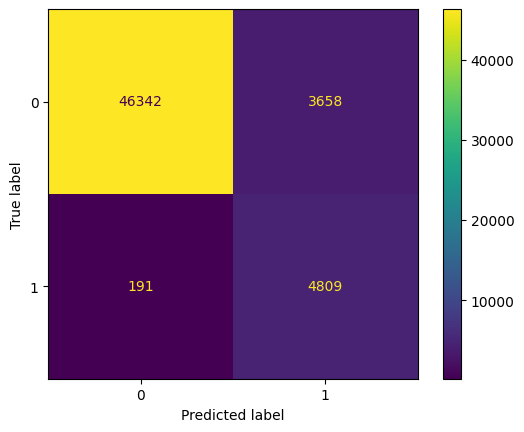

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import FEATURE_NAMES

def model_train(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    return model


def model_predict(model, X_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.03 #plot threshold plot
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred

def cost(tn, fp, fn, tp):
    return (fp * 1 + fn * 10) / (tn + fp + fn + tp)

def information_criterium(cost, features_num):
    return cost + 0.003 * (features_num / len(FEATURE_NAMES))

def eval(data, verbose=True, feature_names=None, n_splits=5):

    if feature_names is None:
        feature_names = FEATURE_NAMES 

    X = data[feature_names]
    y = data['Labels']

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    total_cost = 0
    n_samples = 0

    accuracies = []
    all_y_true = []
    all_y_pred = []

    all_y_scores = []


    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = model_train(X_train, y_train)
        y_pred = model_predict(model, X_test)
        y_scores = model.predict_proba(X_test)[:, 1]

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
        curr_cost = cost(tn, fp, fn, tp)
        total_cost += curr_cost

        accuracies.append(accuracy_score(y_test, y_pred))
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_scores.extend(y_scores)

        if verbose:
            acc = accuracy_score(y_test, y_pred)
            print(f"Fold {fold} Accuracy: {acc:.4f} | FP={fp} FN={fn} | Fold cost={curr_cost}")
        

    if verbose:
        print("\n=== Cross-validated results ===")
        print(f"Mean Accuracy: {sum(accuracies)/n_splits:.4f}")
        print(f"Mean custom cost per sample: {total_cost / n_splits:.4f}\n")
        print("Overall Confusion Matrix:")
        cm= confusion_matrix(all_y_true, all_y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        print("\nClassification Report:")
        print(classification_report(all_y_true, all_y_pred))
 

        
    return total_cost / n_splits

def select_features(data, feature_names, verbose=True, n_splits=5, threshold_info=None):
    current_features = feature_names.copy()

    base_cost = eval(data, feature_names=current_features, verbose=False, n_splits=n_splits)
    best_info = information_criterium(base_cost, len(current_features))

    improving = True
    while improving and len(current_features) > 1:
        improving = False
        info_if_removed = {}

        for feat in current_features:
            test_features = [f for f in current_features if f != feat]
            cost_without_feat = eval(data, feature_names=test_features, verbose=False, n_splits=n_splits)
            info_score = information_criterium(cost_without_feat, len(test_features))
            info_if_removed[feat] = info_score

        feat_to_remove = min(info_if_removed, key=info_if_removed.get)
        min_info = info_if_removed[feat_to_remove]

        if min_info < best_info:
            if verbose:
                print(f"Removing '{feat_to_remove}' improves info criterium: {best_info:.6f} → {min_info:.6f}")
            current_features.remove(feat_to_remove)
            best_info = min_info
            improving = True
        else:
            if verbose:
                print("No further improvement by removing any single feature.")
            break

        if threshold_info is not None and best_info <= threshold_info:
            if verbose:
                print(f"Threshold information criterium reached: {best_info:.6f} <= {threshold_info:.6f}")
            break

    if verbose:
        print("\nSelected features:")
        print(current_features)
        print(f"Final information criterium: {best_info:.6f}")

    return current_features


data = pd.read_pickle("data_with_features.pkl")

selected_feats = select_features(data, FEATURE_NAMES, verbose=False, n_splits=5)
eval(data, True, selected_feats)


# Logical Regression - test dataset

Accuracy: 0.894993532517653
Confusion Matrix:


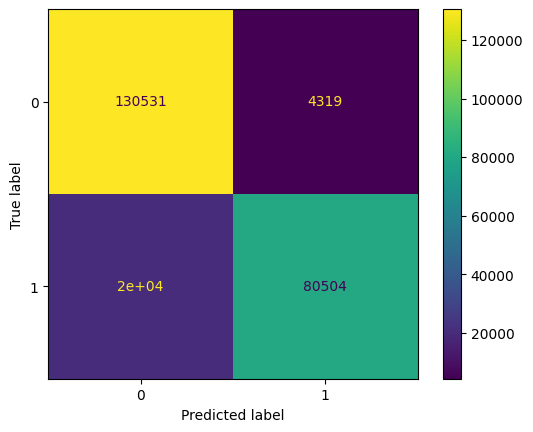


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    134850
           1       0.95      0.80      0.87    100945

    accuracy                           0.89    235795
   macro avg       0.91      0.88      0.89    235795
weighted avg       0.90      0.89      0.89    235795

Accuracy: 0.5173902993880853
Confusion Matrix:


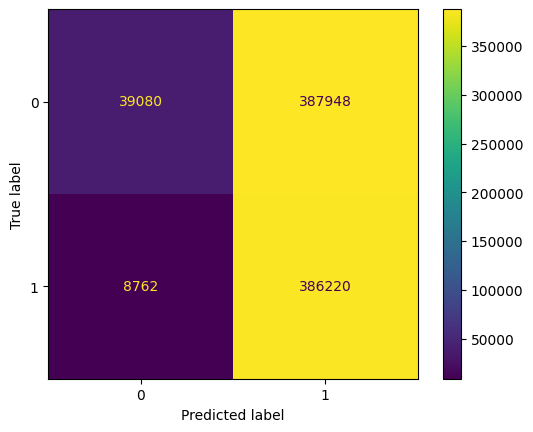


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.09      0.16    427028
           1       0.50      0.98      0.66    394982

    accuracy                           0.52    822010
   macro avg       0.66      0.53      0.41    822010
weighted avg       0.66      0.52      0.40    822010



In [2]:
from features import FEATURES

def get_model(selected_features):
    X = data[selected_feats]
    y = data['Labels']
    model = model_train(X, y)
    return model
    
def add_feature(df, feature):
    TARGET = "URLs"
    df[feature.__name__] = feature(df[TARGET])
    
def get_data(df):
    TARGET = "URLs"
    for feature in FEATURES:
        add_feature(df, feature)
    return df

def eval_model(model, data):

    y_test = 1 - data["Labels"]
    y_pred = model_predict(model, data[selected_feats])


    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

final_model = get_model(selected_feats)
    
out_of_db = pd.read_csv('Many-urls.csv')
out_of_db = get_data(out_of_db)

eval_model(final_model, out_of_db)

out_of_db2 = pd.read_csv('Many-many-urls.csv')
out_of_db2 = get_data(out_of_db2)

eval_model(final_model, out_of_db2)

# Random Forest Classifier - Training

Fold 1 Accuracy: 0.9665 | FP=260 FN=109 | Fold cost=0.12272727272727273
Fold 2 Accuracy: 0.9715 | FP=219 FN=94 | Fold cost=0.10536363636363637
Fold 3 Accuracy: 0.9679 | FP=259 FN=94 | Fold cost=0.109
Fold 4 Accuracy: 0.9686 | FP=242 FN=103 | Fold cost=0.11563636363636363
Fold 5 Accuracy: 0.9693 | FP=230 FN=108 | Fold cost=0.1190909090909091

=== Cross-validated results ===
Mean Accuracy: 0.9688
Mean custom cost per sample: 0.1144

Overall Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     50000
           1       0.79      0.90      0.84      5000

    accuracy                           0.97     55000
   macro avg       0.89      0.94      0.91     55000
weighted avg       0.97      0.97      0.97     55000



np.float64(0.11436363636363638)

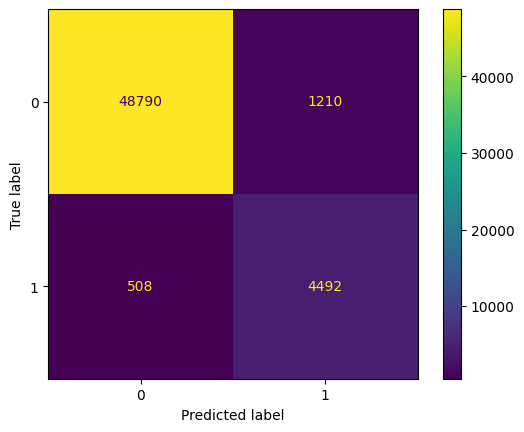

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def model_train(X, y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    return model

def model_predict(model, X_test):
    threshold = 0.35
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred

eval(data, True, selected_feats)

# Random Forest Classifier - Test dataset

Accuracy: 0.5878580970758498
Confusion Matrix:


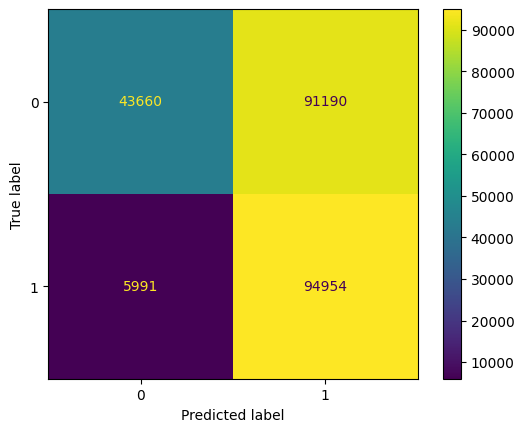


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.32      0.47    134850
           1       0.51      0.94      0.66    100945

    accuracy                           0.59    235795
   macro avg       0.69      0.63      0.57    235795
weighted avg       0.72      0.59      0.55    235795



In [4]:
from features import FEATURES

def get_model(selected_features):
    X = data[selected_feats]
    y = data['Labels']
    model = model_train(X, y)
    return model
    
def add_feature(df, feature):
    TARGET = "URLs"
    df[feature.__name__] = feature(df[TARGET])
    
def get_data(df):
    TARGET = "URLs"
    for feature in FEATURES:
        add_feature(df, feature)
    return df

def eval_model(model, data):

    y_test = 1 - data["Labels"]
    y_pred = model_predict(model, data[selected_feats])


    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

final_model = get_model(selected_feats)
    
out_of_db = pd.read_csv('Many-urls.csv')
out_of_db = get_data(out_of_db)

eval_model(final_model, out_of_db)